## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">0.0 Imports and Settings</p></div>


In [47]:
import pandas  as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import sweetviz          as sv
import shap
from shap import plots 

from IPython.display import HTML
from watermark import watermark 

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn import neighbors as nh
from sklearn import linear_model as lm


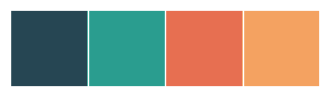

In [2]:
# configurações globais para gŕaficos
sns.set_theme()                                                   
plt.rcParams['figure.figsize'] = [14, 8]                         

LAYOUT_PALETTE = ["#264653","#2a9d8f","#e76f51","#f4a261"]
sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#e76f51")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

cores = ["#264653","#e76f51","#f4a261","#2a9d8f"]

In [3]:
#print(watermark())

In [4]:
#print(watermark(packages="pandas,numpy,seaborn,matplotlib,optuna,scikit-learn,lightgbm,xgboost,shap,watermark"))

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">Helper Functions</p></div>

In [5]:

def jupyter_settings():
    """
    A função jupyter_settings() define e configura algumas opções de exibição e estilo no ambiente Jupyter Notebook.
    Ela ajusta as configurações de exibição do Matplotlib, Pandas e Seaborn para melhorar a experiência de visualização dos dados no notebook.
    
    """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [6]:
#jupyter_settings()

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">0.1 Loading Data</p></div>

In [7]:
data_train_raw = pd.read_csv('dataset/train.csv')
data_test_raw = pd.read_csv('dataset/test.csv')

In [8]:
data_train_raw.shape, data_test_raw.shape

((381109, 12), (127037, 11))

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">1.0 Data Description</p></div>

In [9]:
df_train = data_train_raw.copy()
df_test = data_test_raw.copy()

In [10]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']
df_train.columns = cols_new

In [11]:
num_atributes = df_train.select_dtypes( include=['int64', 'float64'])
cat_atributes = df_train.select_dtypes( exclude=['int64', 'float64'])

In [12]:
num_atributes.describe()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">2.0 Feature Engineering</p></div>

In [13]:
df1 = df_train.copy()

In [14]:
# vehicle_age
df1['vehicle_age'] = df1['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# vehicle_damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">3.0 Exploratory Data Analysis</p></div>

In [15]:
df2 = df1.copy()

In [16]:
my_report = sv.analyze( df_train, target_feat='response')
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Análise Univariada</p></div>

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variável Resposta</p></div> 

Cliente não Interessado: 334399
Cliente Interessado: 46710


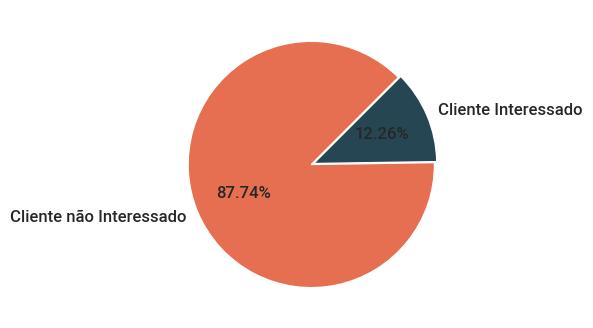

In [17]:
# response
count_class_0 = len(df2[df2['response'] == 0])
count_class_1 = len(df2[df2['response'] == 1])
aux = [count_class_0, count_class_1]

plt.figure(figsize=(8, 4))
plt.pie(aux,
        labels=['Cliente não Interessado', 'Cliente Interessado'],
        colors=['#e76f51', '#264653'],
        explode=(0.01, 0.01),
        startangle=45,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': "white"},
        textprops={'fontsize': 12});

#print(f"Cliente não interessado: {df2['response'].value_counts[0]}")
#print(f"Cliente interessado: {df2['response'].value_counts()[1]}")

print(f"Cliente não Interessado: {count_class_0}")
print(f"Cliente Interessado: {count_class_1}")


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variáveis Numéricas</p></div> 

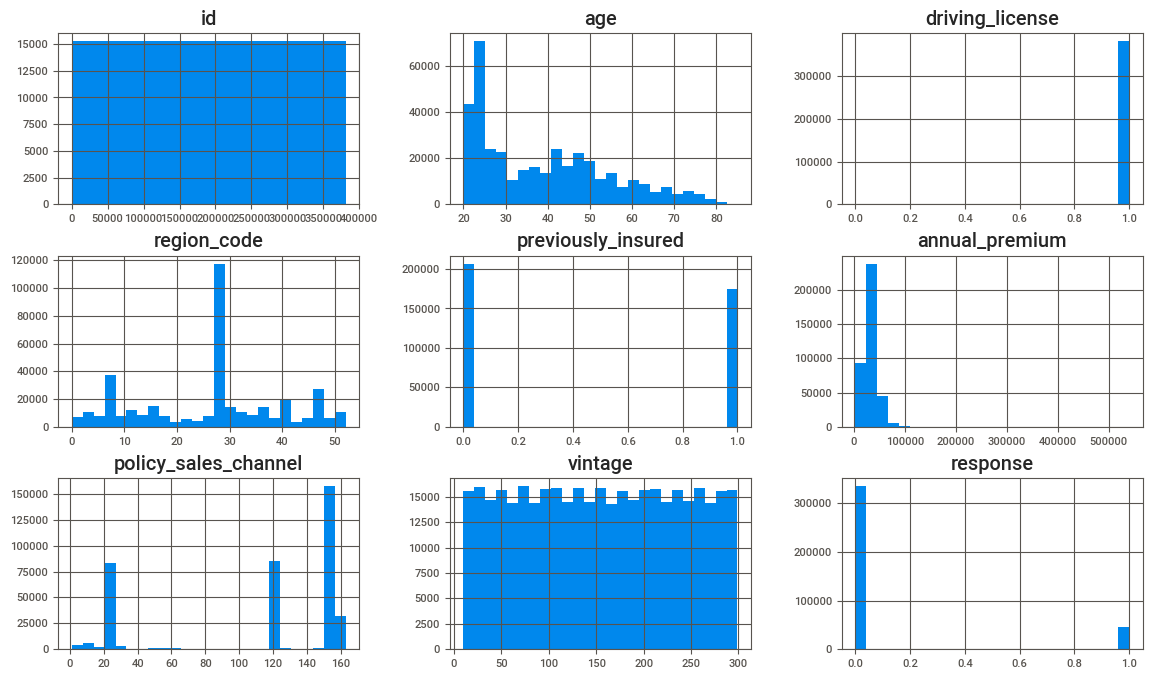

In [18]:
num_atributes.hist( bins=25);

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


<Axes: xlabel='age', ylabel='Count'>

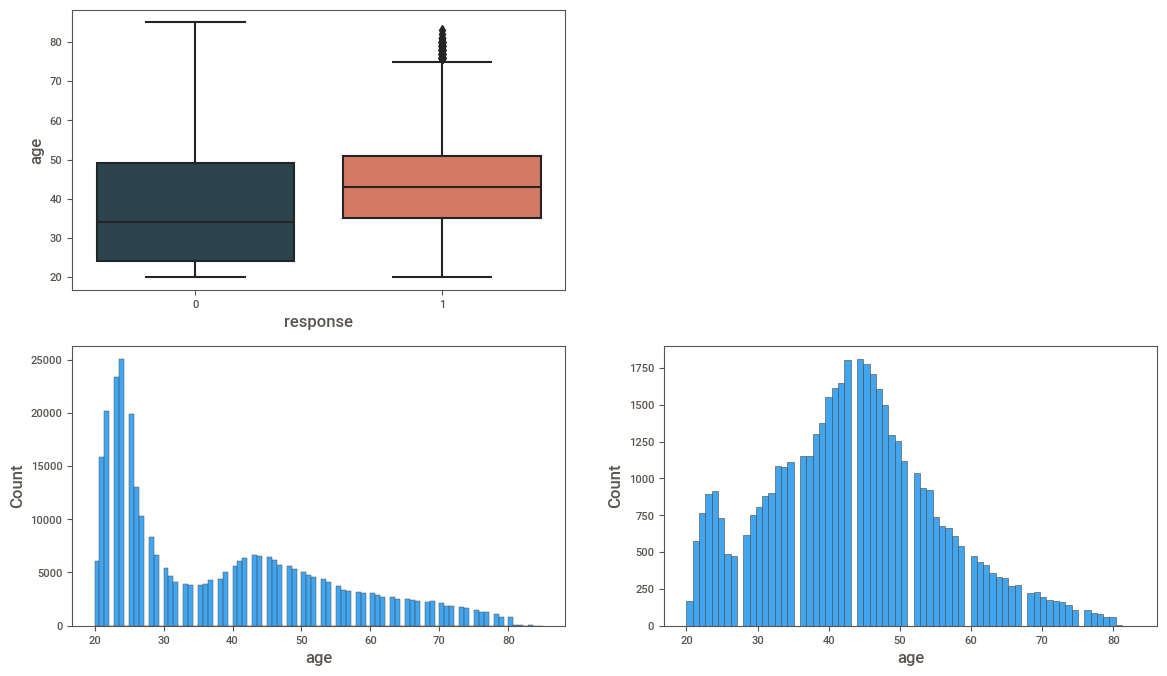

In [19]:
# age
plt.subplot( 2, 2, 1 )
sns.boxplot( data=df2 ,x='response', y='age', palette=cores)

plt.subplot( 2, 2, 3 )
aux0 = df2.loc[df2['response'] == 0 , 'age']
sns.histplot( aux0, palette=cores )

plt.subplot( 2, 2, 4 )
aux0 = df2.loc[df2['response'] == 1 , 'age']
sns.histplot( aux0 , palette=cores)

<Axes: xlabel='response', ylabel='driving_license'>

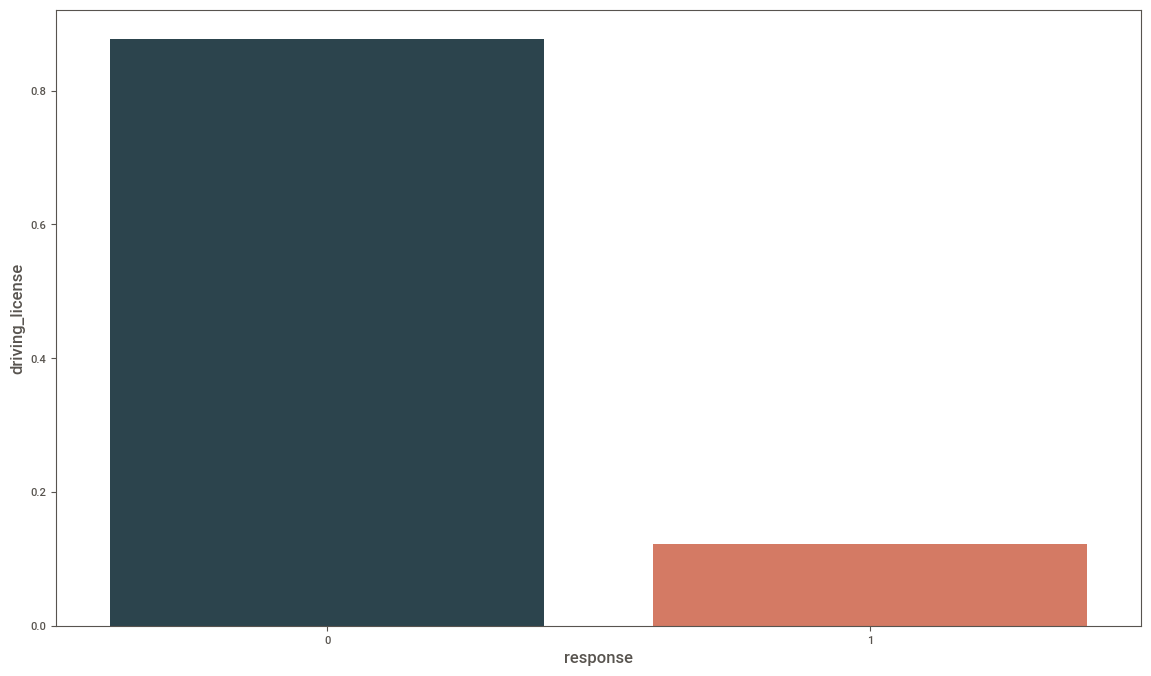

In [20]:
# 'driving_license'
aux = df2[['driving_license', 'response']].groupby( 'response').sum().reset_index()
aux.head()
aux['driving_license'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot( data=aux, x='response', y='driving_license', palette=cores)

<Axes: xlabel='region_code', ylabel='id'>

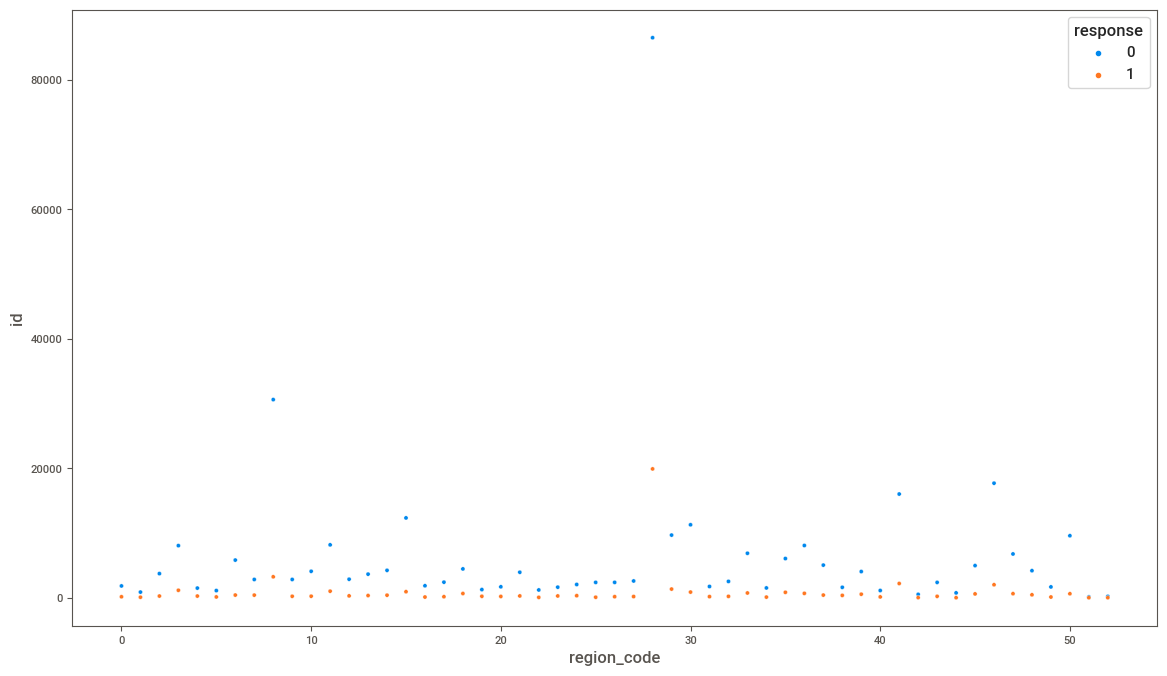

In [21]:
# region_code
aux = df2[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot( data=aux ,x='region_code', y='id', hue='response')

In [22]:
# previously_insured
pd.crosstab( df2['previously_insured'], df2['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


<Axes: xlabel='annual_premium', ylabel='Count'>

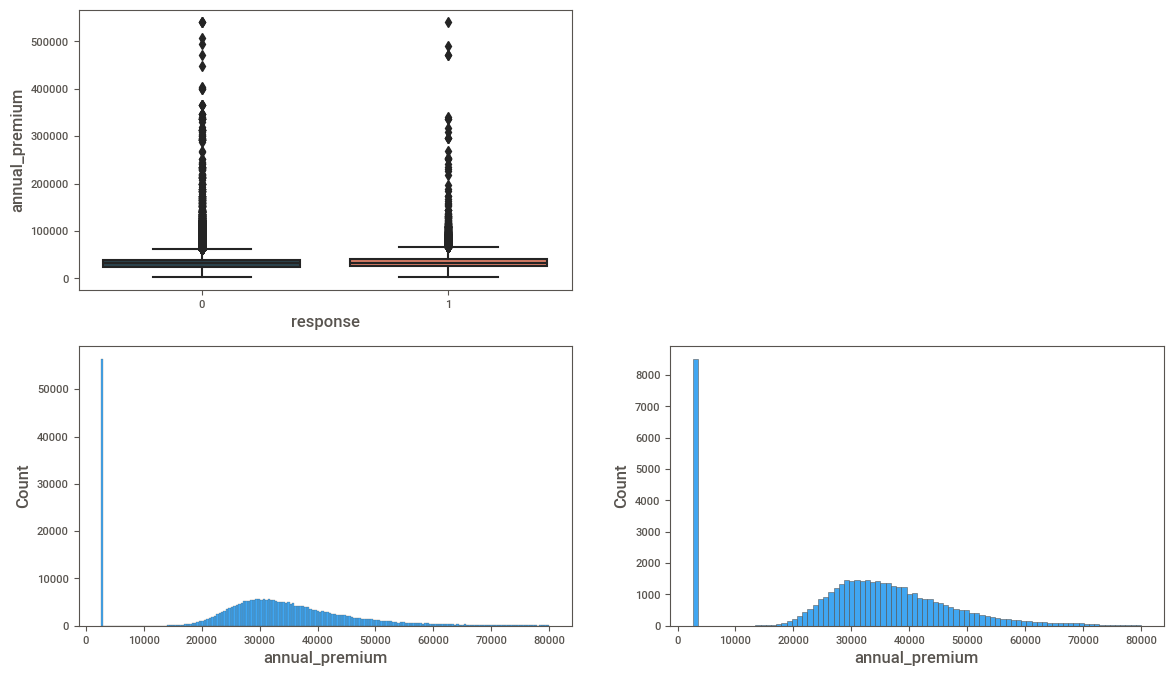

In [23]:
# annual_premium
plt.subplot( 2, 2, 1 )
aux = df2[df2['annual_premium'] < 80000 ]
sns.boxplot( data=df2 ,x='response', y='annual_premium', palette=cores)

plt.subplot( 2, 2, 3 )
aux0 = aux.loc[aux['response'] == 0 , 'annual_premium']
sns.histplot( aux0 )

plt.subplot( 2, 2, 4 )
aux0 = aux.loc[aux['response'] == 1 , 'annual_premium']
sns.histplot( aux0 )

<Axes: xlabel='response', ylabel='policy_sales_channel'>

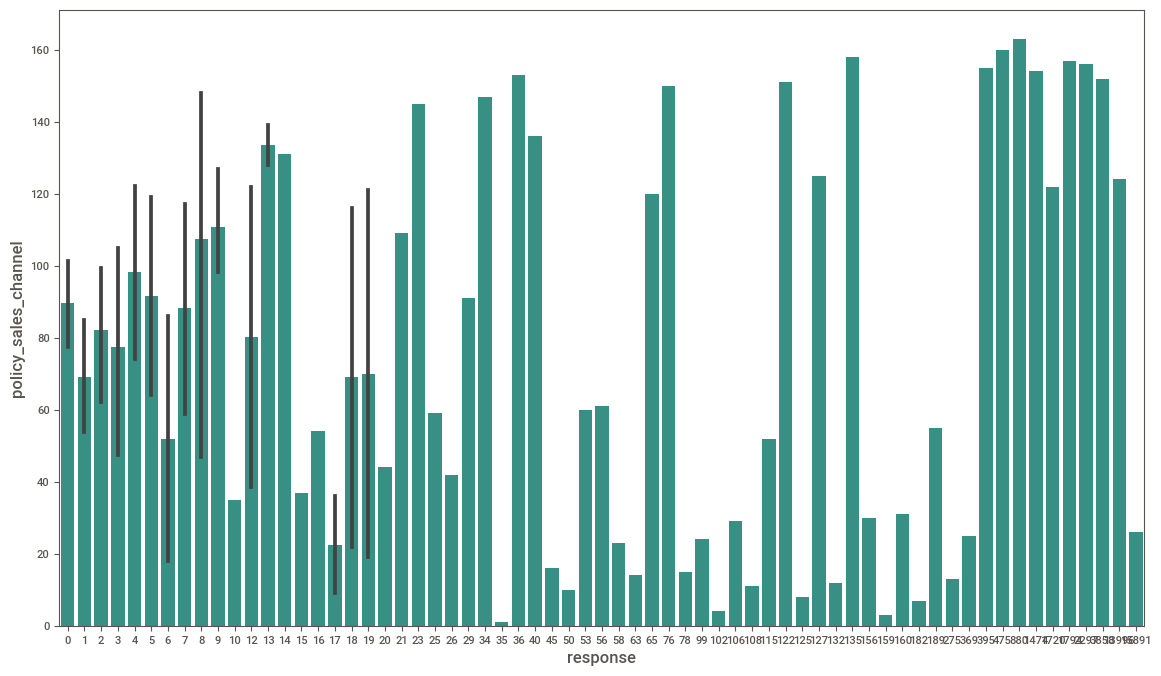

In [24]:
# policy_sales_channel
aux= df2[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( data=aux, x='response', y='policy_sales_channel', color='#2a9d8f' )

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


<Axes: xlabel='vintage', ylabel='Count'>

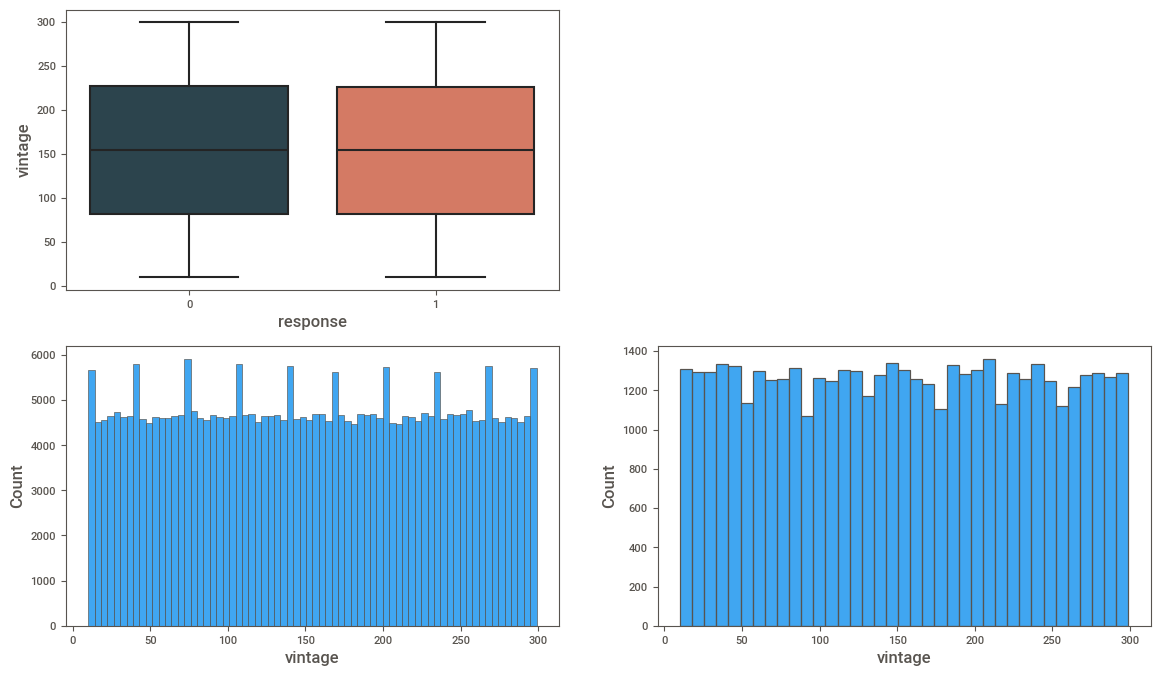

In [25]:
# vintage
plt.subplot( 2, 2, 1 )
sns.boxplot( data=df2 ,x='response', y='vintage', palette=cores)

plt.subplot( 2, 2, 3 )
aux0 = df2.loc[df2['response'] == 0 , 'vintage']
sns.histplot( aux0, palette=cores )

plt.subplot( 2, 2, 4 )
aux0 = df2.loc[df2['response'] == 1 , 'vintage']
sns.histplot( aux0, palette=cores )

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variáveis Categóricas</p></div> 

In [26]:
cat_atributes.apply( lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [27]:
df2['vehicle_damage'].value_counts()

vehicle_damage
1    192413
0    188696
Name: count, dtype: int64

<Axes: xlabel='response', ylabel='Density'>

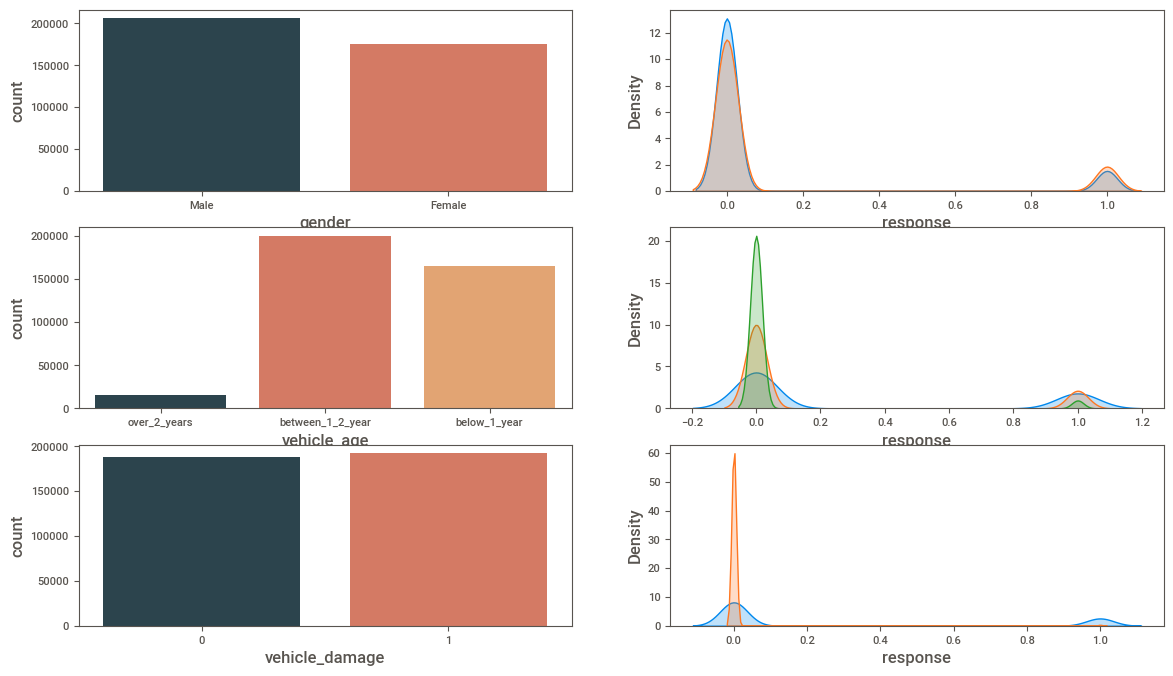

In [28]:
# Gender
plt.subplot( 3, 2, 1 )
sns.countplot(df2, x='gender', palette=cores)
plt.subplot( 3, 2, 2 )
sns.kdeplot( df2[df2['gender'] == 'Female']['response'], label='Female', fill=True )
sns.kdeplot( df2[df2['gender'] == 'Male']['response'], label='Male', fill=True )
#vehicle_age
plt.subplot( 3, 2, 3 )
sns.countplot( df2, x='vehicle_age', palette=cores)
plt.subplot( 3, 2, 4 )
sns.kdeplot(  df2[ df2['vehicle_age'] == 'over_2_years']['response'], label='Loyal Customer', fill=True )
sns.kdeplot( df2[df2['vehicle_age'] == 'between_1_2_year']['response'], label='disloyal Customer', fill=True )
sns.kdeplot( df2[df2['vehicle_age'] == 'below_1_year']['response'], label='disloyal Customer', fill=True )
# vehicle_damage
plt.subplot( 3, 2, 5 )
sns.countplot( df2,  x='vehicle_damage', palette=cores)
plt.subplot( 3, 2, 6 )
sns.kdeplot( df2[df2['vehicle_damage'] == 1 ]['response'], label='Foi Danificado', fill=True )
sns.kdeplot( df2[df2['vehicle_damage'] == 0 ]['response'], label='Não Danificado', fill=True )



In [29]:
# vehicle_age
df2[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Análise Bivariada</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Análise Multivariada</p></div>

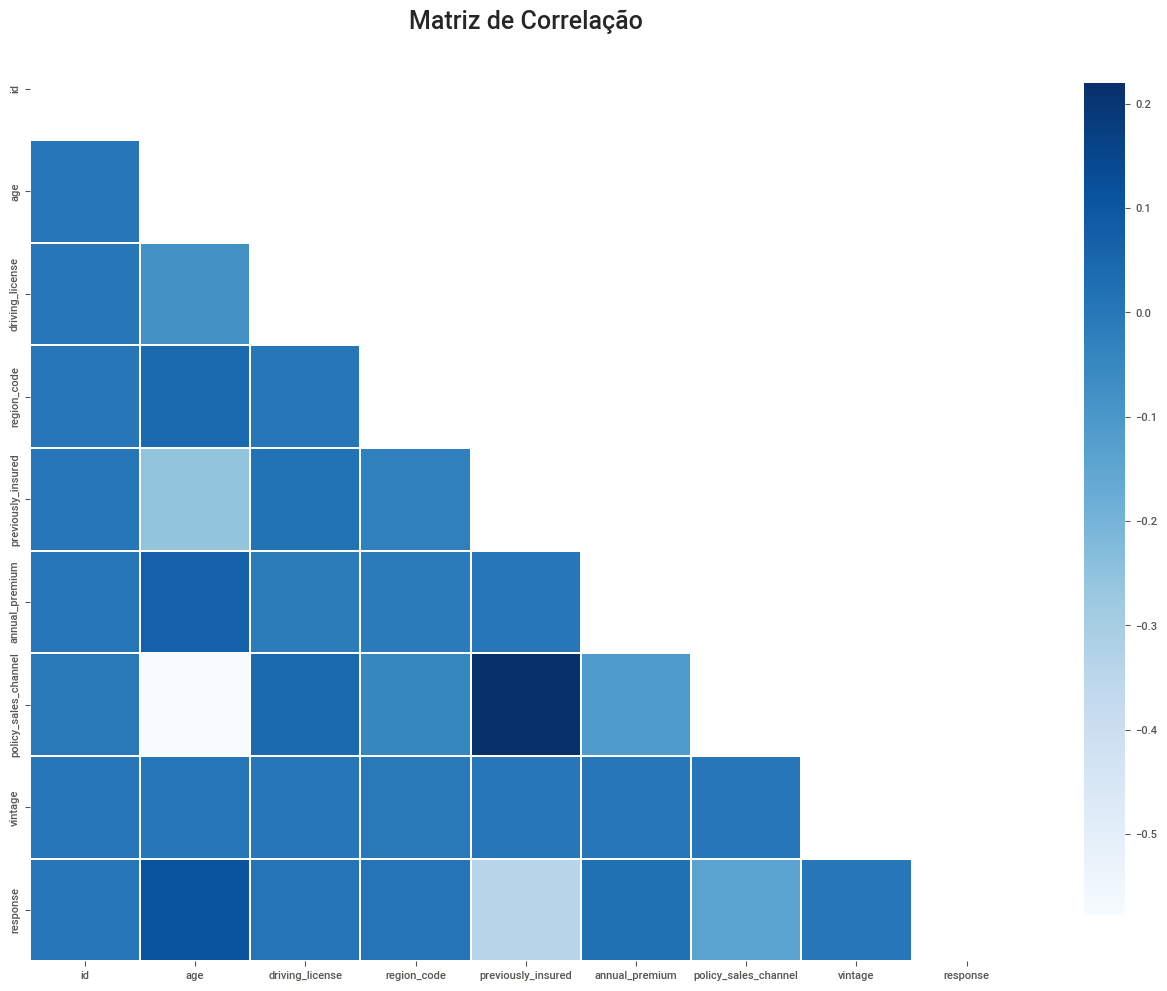

In [30]:
# Cria Matriz de correlação das variaveis numericas
mask = np.zeros_like(num_atributes.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Matriz de Correlação',fontsize=18)
sns.heatmap(num_atributes.corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=False,mask=mask,annot_kws={"size":10},cbar_kws={"shrink": .9});

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">4.0 Data Preparation</p></div>

In [31]:
df3 = df2.copy()

In [67]:
X = df2.drop( 'response', axis=1 )
y = df2[ 'response'].copy()

# separação entre treino(80%) e teste(20%)
X_train, X_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20, random_state = 42)

df3 = pd.concat( [X_train, y_train], axis=1 )

X_train.shape, y_train.shape, X_validation.shape, y_val.shape

((304887, 11), (304887,), (76222, 11), (76222,))

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Standardization</p></div>

In [68]:
ss = pp.StandardScaler()

#annual_premium
df3['annual_premium'] = ss.fit_transform( df3[['annual_premium']].values )

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Rescaling</p></div>

In [69]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df3['age'] = mms_age.fit_transform( df3[['age']].values )

#vintage
df3['vintage'] = mms_vintage.fit_transform( df3[['vintage']].values )

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Encoder</p></div>

In [70]:
# gender - Label Encoder
gender_dict = {'Male': 0, 'Female': 1}
df3['gender'] = df3['gender'].map( gender_dict )

#region_code  Frequency Encoding 
fe_encode_region_code = df3.groupby( 'region_code' ).size() / len (df3)
df3.loc[ : , 'region_code'] = df3['region_code'].map( fe_encode_region_code )

#vehicle_age - Ordinal Encoding  
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_year': 2, 'over_2_years': 3}
df3['vehicle_age'] = df3['vehicle_age'].map( vehicle_age_dict )

# policy_sales_channel  *Frequency Encoding 
fe_encode_policy = df3.groupby( 'policy_sales_channel' ).size() / len (df3)
df3.loc[ : , 'policy_sales_channel'] = df3['policy_sales_channel'].map( fe_encode_policy )



### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Validation Preparation</p></div>

In [71]:
# gender
X_validation.loc[:, 'gender'] = X_validation.loc[:, 'gender'].map( gender_dict )

#region_code
X_validation.loc[:, 'region_code'] = X_validation.loc[:, 'region_code'].map( fe_encode_region_code )

#vehicle_age
X_validation.loc[:, 'vehicle_age'] = X_validation.loc[:, 'vehicle_age'].map( vehicle_age_dict)

# policy_sales_channel
X_validation.loc[:, 'policy_sales_channel'] = X_validation.loc[:, 'policy_sales_channel'].map( fe_encode_policy )

# fillna
X_validation = X_validation.fillna( 0 )


In [72]:
#age
X_validation.loc[:, 'age'] = mms_age.transform( X_validation[['age']].values )

#vintage
X_validation.loc[:, 'vintage'] = mms_vintage.transform( X_validation[['vintage']].values )

#annual_premium
X_validation.loc[:, 'annual_premium'] = ss.transform( X_validation[['annual_premium']].values )


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">5.0 Feature Selection </p></div>

In [73]:
#data preparation
X_train_fs = df3.drop( 'response', axis=1)
y_train_fs = y_train.values

In [39]:
# Treina modelo simples para entender a importancia de cada feature no modelo 
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train_fs, y_train_fs)
explainer = shap.Explainer(lgbm_model, X_train_fs)
shap_values = explainer(X_train_fs)

[LightGBM] [Info] Number of positive: 37187, number of negative: 267700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121970 -> initscore=-1.973908
[LightGBM] [Info] Start training from score -1.973908


100%|===================| 304612/304887 [14:39<00:00]        

In [40]:
#Inicializa ambiente biblioteca Shap
shap.initjs()

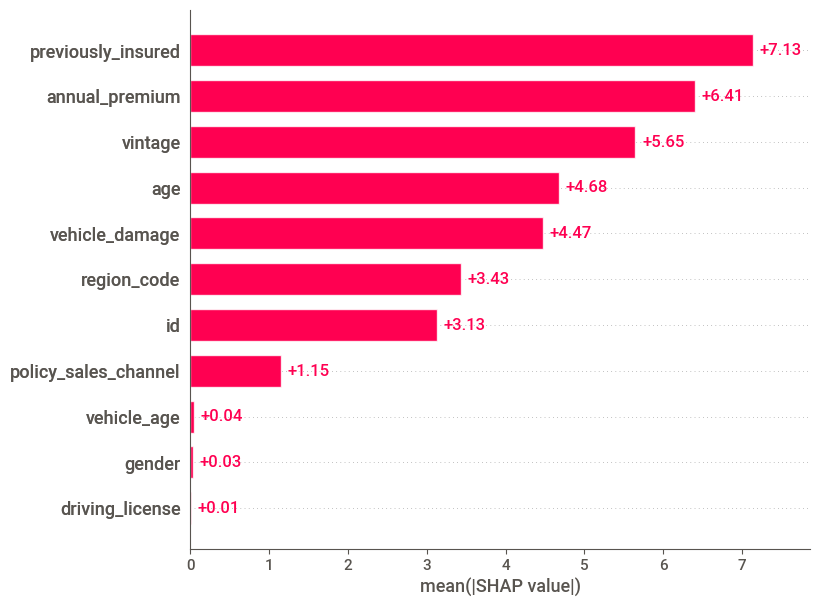

In [41]:
#Explicabilidade Geral, média de contribuição de cada feature para tomada de decisão do modelo
shap.plots.bar(shap_values, max_display=25)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">6.0 Machine Learning</p></div>

In [74]:
cols_selected = [ 'age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium','policy_sales_channel', 'vintage']

In [83]:
X_train = df3[ cols_selected]
X_val = X_validation[ cols_selected]
y_val = y_validation.copy()

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">KNN</p></div> 

In [84]:
# Definicao do modelo
knn_model = nh.KNeighborsClassifier( n_neighbors=7)

# Treinamento do Modelo
knn_model.fit( X_train, y_train )

# Predição modelo - Poder de generalização
yhat_knn = knn_model.predict_proba( X_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

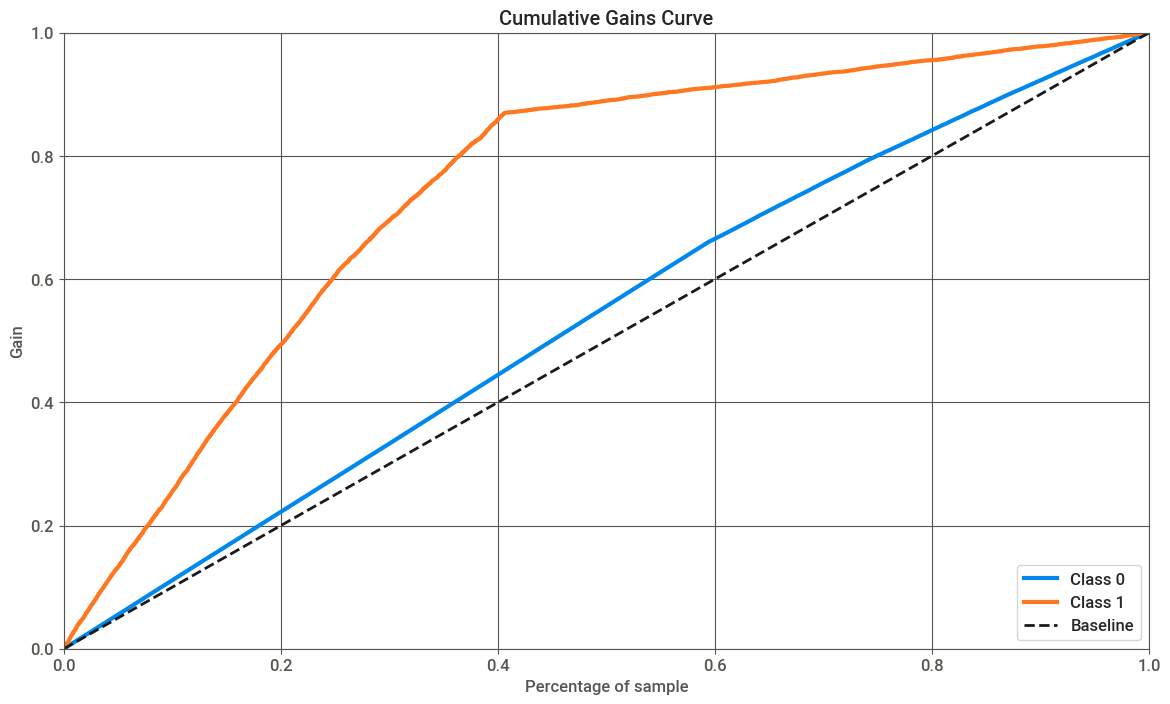

In [85]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn)

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Linear Regression</p></div> 

In [86]:
# Definicao do modelo
lr_model = lm.LogisticRegression( random_state=42)

# Treinamento do Modelo
lr_model.fit( X_train, y_train )

# Predição modelo - Poder de generalização
yhat_lr = lr_model.predict_proba( X_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

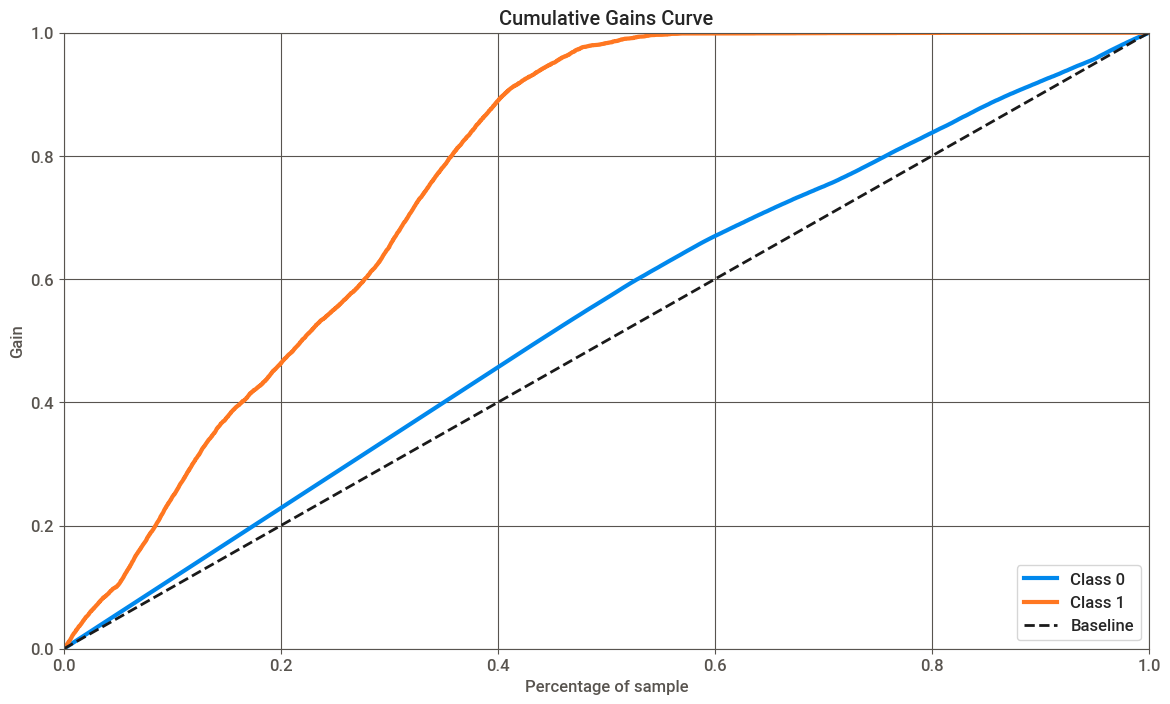

In [87]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr)

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Random Forest</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">7.0 Model Performance</p></div>

In [111]:
def precision_at_k( data, k=2000):
    # reset index
    data = data.reset_index( drop=True)

    # created ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [112]:
def recall_at_k( data, k=2000):
    # reset index
    data = data.reset_index( drop=True)

    # created ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [113]:
#copy data
df7 = X_validation.copy()
df7['response'] = y_validation.copy()

#Propensity score
df7['score'] = yhat_knn[:, 1].tolist()

#Sorted clients by propensity score
df7 = df7.sort_values( 'score', ascending=False)

#compute precision at k
precision_at_50 = precision_at_k(df7, k=50)
print('Precision at K:{}'.format(precision_at_50))
#compute precision at k
recall_at_50 = recall_at_k(df7, k=50)
print('Recall at K:{}'.format(recall_at_50))

Precision at K:0.47058823529411764
Recall at K:0.002520214218208548
